# 1. Data Overview

###  Import libraries and load datasets

In [1]:
!pip install -U gensim

Requirement already up-to-date: gensim in c:\users\lukef\anaconda3\lib\site-packages (3.8.3)


In [155]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_test = pd.read_csv(r'C:\Users\lukef\Downloads\Disaster_Tweets\Disaster_Tweets\test.csv')
df_train = pd.read_csv(r'C:\Users\lukef\Downloads\Disaster_Tweets\Disaster_Tweets\train.csv')

### Survey Datasets

In [4]:
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print(df_test.dtypes)

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


In [7]:
print(df_train.dtypes)

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


# 2. Data Preprocessing

### Clean Test Data

To determine whether a tweet is relating to a disaster, we don't need the id or location columns. Let's drop them.

In [8]:
df_test=df_test[['keyword','text','target']]
df_test.head()

,keyword,text,target
0,NaN,Just happened a terrible car crash,1
1,NaN,"Heard about #earthquake is different cities, s...",1
2,NaN,"there is a forest fire at spot pond, geese are...",1
3,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [9]:
# Replace fields that are entirely space (or empty) with NaN
df_test=df_test.replace(r'^\s*$', np.nan, regex=True)
print(df_test)

     keyword                                               text  target
0        NaN                 Just happened a terrible car crash       1
1        NaN  Heard about #earthquake is different cities, s...       1
2        NaN  there is a forest fire at spot pond, geese are...       1
3        NaN           Apocalypse lighting. #Spokane #wildfires       1
4        NaN      Typhoon Soudelor kills 28 in China and Taiwan       1
...      ...                                                ...     ...
3258     NaN  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...       0
3259     NaN  Storm in RI worse than last hurricane. My city...       1
3260     NaN  Green Line derailment in Chicago http://t.co/U...       1
3261     NaN  MEG issues Hazardous Weather Outlook (HWO) htt...       1
3262     NaN  #CityofCalgary has activated its Municipal Eme...       1

[3263 rows x 3 columns]


In [10]:
# Search for missing NaN data.True = missing, false = present
missing_data_test = df_test.isnull()
missing_data_test.head()

,keyword,text,target
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [11]:
# Use a for loop to count missing data:
for column in missing_data_test.columns.values.tolist():
    print(column)
    print (missing_data_test[column].value_counts())
    print("")

keyword
False    3237
True       26
Name: keyword, dtype: int64

text
False    3263
Name: text, dtype: int64

target
False    3263
Name: target, dtype: int64



Based on the above:

1. keyword: 26 missing data
2. text: 0 missing data
3. target: 0 missing data

The keyword column has comparitively few missing values relative to size of the dataset. We could find the most frequently occuring value and replace the empty fields with it.

In [12]:
# We can use .idxmax() to find the most common occuring value in column keyword
df_test['keyword'].value_counts().idxmax()

'deluged'

In [13]:
#df_test["keyword"].replace(np.nan, "deluged", inplace=True)

We can see below that the word "deluged" is the most frequent, but it is not far and away the frequent with many other words (see below). It's not really fair to assume the keyword of all the tweets is "deluged". Therefore, we do not proceed with the replace function above.

In [14]:
df_test['keyword'].value_counts()

deluged                  23
demolished               22
rubble                   22
snowstorm                21
first%20responders       21
                         ..
radiation%20emergency     5
fatalities                5
forest%20fire             5
inundation                4
epicentre                 1
Name: keyword, Length: 221, dtype: int64

Instead, let's drop the rows with missing data so that we have consistency across the dataframe.

In [15]:
df_test.dropna(inplace=True)
df_test=df_test.dropna()
df_test.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

In [16]:
df_test.head()

,keyword,text,target
15,ablaze,Birmingham Wholesale Market is ablaze BBC News...,1
16,ablaze,@sunkxssedharry will you wear shorts for race ...,0
17,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriage...,0
18,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
19,ablaze,PSA: IÛªm splitting my personalities.\n\n?? t...,0


This has misaligned the indexes, so they will be reset. Let's then double check the data types of combi to make sure they're of the correct type.

In [17]:
df_test.reset_index(drop=True, inplace=True)

In [18]:
df_test.dtypes

keyword    object
text       object
target      int64
dtype: object

Looks ok: strings are objects, numerical values are ints.

The most common word is not dominantly occuring to justify replacing NA values with it. Instead, since there are not many NA rows, let's drop them.

### Clean Train Data

In [19]:
df_train=df_train[['keyword','text','target']]
df_train.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
# Replace fields that are entirely space (or empty) with NaN
df_train=df_train.replace(r'^\s*$', np.nan, regex=True)
print(df_train)

     keyword                                               text  target
0        NaN  Our Deeds are the Reason of this #earthquake M...       1
1        NaN             Forest fire near La Ronge Sask. Canada       1
2        NaN  All residents asked to 'shelter in place' are ...       1
3        NaN  13,000 people receive #wildfires evacuation or...       1
4        NaN  Just got sent this photo from Ruby #Alaska as ...       1
...      ...                                                ...     ...
7608     NaN  Two giant cranes holding a bridge collapse int...       1
7609     NaN  @aria_ahrary @TheTawniest The out of control w...       1
7610     NaN  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611     NaN  Police investigating after an e-bike collided ...       1
7612     NaN  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 3 columns]


In [21]:
# Search for missing NaN data.True = missing, false = present
missing_data_train = df_train.isnull()
missing_data_train.head()

,keyword,text,target
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [22]:
# Use a for loop to count missing data:
for column in missing_data_train.columns.values.tolist():
    print(column)
    print (missing_data_train[column].value_counts())
    print("")

keyword
False    7552
True       61
Name: keyword, dtype: int64

text
False    7613
Name: text, dtype: int64

target
False    7613
Name: target, dtype: int64



In [23]:
# We can use .idxmax() to find the most common occuring value in column keyword
df_train['keyword'].value_counts().idxmax()

'fatalities'

In [24]:
df_train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [25]:
df_train.dropna(inplace=True)
df_train=df_train.dropna()
df_train.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

In [26]:
df_train.head()

,keyword,text,target
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,Crying out for more! Set me ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [27]:
df_train.reset_index(drop=True, inplace=True)

In [28]:
df_train.dtypes

keyword    object
text       object
target      int64
dtype: object

# 3. Clean Text

### Clean Test Text

In [29]:
df_test['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

We can see that there is punctuation that would challenge the NPL. Let's remove this.

In [30]:
df_test['keyword']=df_test['keyword'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [31]:
df_test['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown20up', 'body20bag', 'body20bagging', 'body20bags',
       'bomb', 'bombed', 'bombing', 'bridge20collapse',
       'buildings20burning', 'buildings20on20fire', 'burned', 'burning',
       'burning20buildings', 'bush20fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical20emergency',
       'cliff20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed', 'derailment

Since the above failed to remove numeric characters, let's remove numbers from the tweet keywords, as digits will confuse the NPL. The 20 we saw previously denoted spaces, so we will replace them with spaces, too.

In [32]:
#df_test['keyword']=df_test['keyword'].apply(lambda x: re.sub('\w*\d\w*','', x))
df_test['keyword']=df_test['keyword'].apply(lambda x: re.sub('\d',' ', x))

In [33]:
df_test['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane  accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew  up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown  up', 'body  bag', 'body  bagging', 'body  bags',
       'bomb', 'bombed', 'bombing', 'bridge  collapse',
       'buildings  burning', 'buildings  on  fire', 'burned', 'burning',
       'burning  buildings', 'bush  fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical  emergency',
       'cliff  fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed', 'derailment

Now we can exmaine column text to see what needs to be cleaned.

In [34]:
for index,text in enumerate(df_test['text'][35:40]):
  print('Tweet %d:\n'%(index+1),text)

Tweet 1:
 Stop saying 'I Wish' and start saying 'I Will'. ÛÒ Unknown
Tweet 2:
 I want to go to Aftershock in October because it has all the bands I listen to and #NXT! Can't afford it yet though. #gradschoolapps
Tweet 3:
 'We are still living in the aftershock of Hiroshima people are still the scars of history.' - Edward Bond http://t.co/engTl5wrGp
Tweet 4:
 320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29
Tweet 5:
 Aftershock https://t.co/Ecy4U623nO


Here, you can see that we have some contractions like “It’s”, numbers like “320” and punctuations like “,”, "#", “!”,“.” and so forth present in the tweets. We’ll handle these and other problems by performing the below operations:

1. Expand contractions
2. Lowercase the tweets
3. Remove URLs
4. Remove digits and words containing digits
5. Remove punctuations
6. Remove words with three or less letters
7. Remove @ handles
8. Remove excess whitespace between text

Let’s start by expanding contractions using a dictionary containing English contractions to expand.

In [35]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the tweets
df_test['text']=df_test['text'].apply(lambda x:expand_contractions(x))

Then, lowercase the words.

In [36]:
df_test['text']=df_test['text'].apply(lambda x: x.lower())

Remove URLs in the tweets.

In [37]:
df_test['text'] = df_test['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df_test['text'] = df_test['text'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])

Next, we need to remove numbers and words containing digits from the tweets.

In [38]:
df_test['text']=df_test['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

Now, remove the punctuations and any non alphanumeric characters.

In [39]:
df_test['text'] = df_test['text'].str.replace("[^a-zA-Z#]", " ")

Remove any words that are three letters or less, as these are usually nondescript.

In [40]:
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [41]:
# Funtion to remove @ handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

df_test['text'] = np.vectorize(remove_pattern)(df_test['text'], "@[\w]*")

Finally, let's get rid of any consecutive whitespace in the text.

In [42]:
df_test.text = df_test.text.replace('\s+', ' ', regex=True)

Review again.

In [43]:
df_test.head()

,keyword,text,target
0,ablaze,birmingham wholesale market ablaze news fire b...,1
1,ablaze,sunkxssedharry will wear shorts race ablaze,0
2,ablaze,#previouslyondoyintv toke makinwa marriage cri...,0
3,ablaze,check these,0
4,ablaze,splitting personalities techies follow ablaze ...,0


In [44]:
for index,text in enumerate(df_test['text'][35:40]):
  print('Tweet %d:\n'%(index+1),text)

Tweet 1:
 stop saying wish start saying will unknown
Tweet 2:
 want aftershock october because bands listen #nxt afford though #gradschoolapps
Tweet 3:
 still living aftershock hiroshima people still scars history edward bond
Tweet 4:
 icemoon aftershock
Tweet 5:
 aftershock


### Clean Train Text

In [45]:
df_train['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [46]:
df_train['keyword']=df_train['keyword'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [47]:
df_train['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown20up', 'body20bag', 'body20bagging', 'body20bags',
       'bomb', 'bombed', 'bombing', 'bridge20collapse',
       'buildings20burning', 'buildings20on20fire', 'burned', 'burning',
       'burning20buildings', 'bush20fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical20emergency',
       'cliff20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed', 'derailment

In [48]:
df_train['keyword']=df_train['keyword'].apply(lambda x: re.sub('\d',' ', x))

In [49]:
df_train['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane  accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew  up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown  up', 'body  bag', 'body  bagging', 'body  bags',
       'bomb', 'bombed', 'bombing', 'bridge  collapse',
       'buildings  burning', 'buildings  on  fire', 'burned', 'burning',
       'burning  buildings', 'bush  fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical  emergency',
       'cliff  fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed', 'derailment

In [50]:
for index,text in enumerate(df_train['text'][35:40]):
  print('Tweet %d:\n'%(index+1),text)

Tweet 1:
 @ablaze what time does your talk go until? I don't know if I can make it due to work.
Tweet 2:
 'I can't have kids cuz I got in a bicycle accident &amp; split my testicles. it's impossible for me to have kids' MICHAEL YOU ARE THE FATHER
Tweet 3:
 Accident on I-24 W #NashvilleTraffic. Traffic moving 8m slower than usual. https://t.co/0GHk693EgJ
Tweet 4:
 Accident center lane blocked in #SantaClara on US-101 NB before Great America Pkwy #BayArea #Traffic http://t.co/pmlOhZuRWR
Tweet 5:
 http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice &amp; see how a #solicitor can help #OtleyHour


In [51]:
# Expanding Contractions in the tweets
df_train['text']=df_train['text'].apply(lambda x:expand_contractions(x))

In [52]:
df_train['text']=df_train['text'].apply(lambda x: x.lower())

In [53]:
df_train['text'] = df_train['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df_train['text'] = df_train['text'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])

In [54]:
df_train['text']=df_train['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [55]:
df_train['text'] = df_train['text'].str.replace("[^a-zA-Z#]", " ")

In [56]:
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [57]:
# Funtion to remove @ handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

df_train['text'] = np.vectorize(remove_pattern)(df_train['text'], "@[\w]*")

In [58]:
df_train.text = df_train.text.replace('\s+', ' ', regex=True)

In [59]:
df_train.head()

,keyword,text,target
0,ablaze,bbcmtd wholesale markets ablaze,1
1,ablaze,always bring heavy #metal,0
2,ablaze,#africanbaze breaking news nigeria flag ablaze,1
3,ablaze,crying more ablaze,0
4,ablaze,plus side look last night ablaze,0


In [60]:
for index,text in enumerate(df_train['text'][35:40]):
  print('Tweet %d:\n'%(index+1),text)

Tweet 1:
 ablaze what time does your talk until know make work
Tweet 2:
 cannot have kids bicycle accident split testicles impossible have kids michael father
Tweet 3:
 accident #nashvilletraffic traffic moving slower than usual
Tweet 4:
 accident center lane blocked #santaclara before great america pkwy #bayarea #traffic
Tweet 5:
 


# 4. Preparing Text Data for Exploratory Data Analysis (EDA)

### Tokenizing Test Data with  NLTK

First, we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

We will then use nltk's PorterStemmer() function to normalize the tweets.

In [61]:
tokenized_tweet_test = df_test['text'].apply(lambda x: x.split()) # tokenizing

In [62]:
tokenized_tweet_test.head()

0    [birmingham, wholesale, market, ablaze, news, ...
1    [sunkxssedharry, will, wear, shorts, race, abl...
2    [#previouslyondoyintv, toke, makinwa, marriage...
3                                       [check, these]
4    [splitting, personalities, techies, follow, ab...
Name: text, dtype: object

Now, normalize with PorterStemmer().

In [63]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet_test = tokenized_tweet_test.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

Finally, bring the tokens back together.

In [64]:
for i in range(len(tokenized_tweet_test)):
    tokenized_tweet_test[i] = ' '.join(tokenized_tweet_test[i])
    
df_test['text'] = tokenized_tweet_test

### Tokenizing Train Data for NLTK

In [65]:
tokenized_tweet_train = df_train['text'].apply(lambda x: x.split()) # tokenizing

In [66]:
tokenized_tweet_train.head()

0                 [bbcmtd, wholesale, markets, ablaze]
1                       [always, bring, heavy, #metal]
2    [#africanbaze, breaking, news, nigeria, flag, ...
3                               [crying, more, ablaze]
4              [plus, side, look, last, night, ablaze]
Name: text, dtype: object

In [67]:
tokenized_tweet_train = tokenized_tweet_train.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [68]:
for i in range(len(tokenized_tweet_train)):
    tokenized_tweet_train[i] = ' '.join(tokenized_tweet_train[i])
    
df_train['text'] = tokenized_tweet_train

# 5. Exploratory Data Analysis on Train Data

### Visualizing With Wordclouds

Let’s start by looking at the common words present in the tweets using a word cloud.

In [69]:
# Install WordCloud
!pip install wordcloud

In [70]:
# Import WordCloud and matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

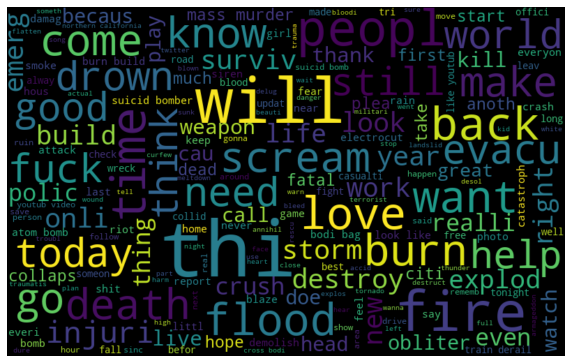

In [71]:
# Visualize all words in tweets
all_words = ' '.join([text for text in df_train['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see many of the words are positive or neutral. They don't give us an idea about the words associated with disaster-related tweets. Hence, we will plot separate wordclouds for both the classes(disaster-related or not), starting with the latter.

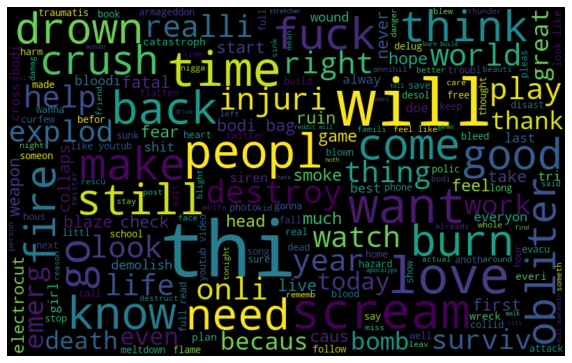

In [72]:
normal_words =' '.join([text for text in df_train['text'][df_train['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Now, we will visualize words in disaster-related tweets.

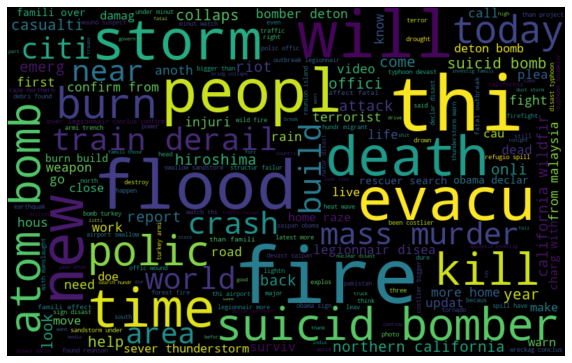

In [73]:
negative_words = ' '.join([text for text in df_train['text'][df_train['target'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Sentiment Analysis of Tweets

We can check tweets for polarity to see which are negative and which are positive. If the tweets contain positive language, it is less likely that they are related to actual disasters; if there is negative sentiment present, they may refer to real disasters. 

In [74]:
# Install TextBlob
!pip install -U textblob

Requirement already up-to-date: textblob in c:\users\lukef\anaconda3\lib\site-packages (0.15.3)


In [75]:
# Import TextBlob and apply to df_test
from textblob import TextBlob

df_train['polarity']=df_train['text'].apply(lambda x:TextBlob(x).sentiment.polarity)

We can randomly select three tweets with positive language.

In [76]:
print("3 Random Tweets with Highest Polarity:")
for index,tweet in enumerate(df_train.iloc[df_train['polarity'].sort_values(ascending=False)[:3].index]['text']):
  print('Tweet {}:\n'.format(index+1),tweet)

3 Random Tweets with Highest Polarity:
Tweet 1:
 demolish person best
Tweet 2:
 nugget #fettilootch #slanglucci oppress greatest danger come soon album
Tweet 3:
 thi australia best burger


Similarly, we can randomly select three tweets with negative language.

In [77]:
print("3 Random Reviews with Lowest Polarity:")
for index,tweet in enumerate(df_train.iloc[df_train['polarity'].sort_values(ascending=True)[:3].index]['text']):
  print('Tweet {}:\n'.format(index+1),tweet)

3 Random Reviews with Lowest Polarity:
Tweet 1:
 legionnair diseas what be done stop deadli outbreak worst ever outbreak legio
Tweet 2:
 thi evil gener rock roll evacu
Tweet 3:
 nickcocofre juliedicaro worst person question juli attack guy have empathi


You can see that according to this sampling of polarity, more words in tweets with target variable 1 are negative.

### Analyzing Hashtags

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.

Let's store all the trend terms in two separate lists — one for non-disaster tweets and the other for disaster tweets.

In [78]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [79]:
# extracting hashtags from non-disaster tweets

HT_regular = hashtag_extract(df_train['text'][df_train['target'] == 0])

# extracting hashtags from disaster tweets
HT_negative = hashtag_extract(df_train['text'][df_train['target'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

We can now display the non-disaster hashtags.

In [80]:
# Import seaborn for displaying our barcharts
import seaborn as sns

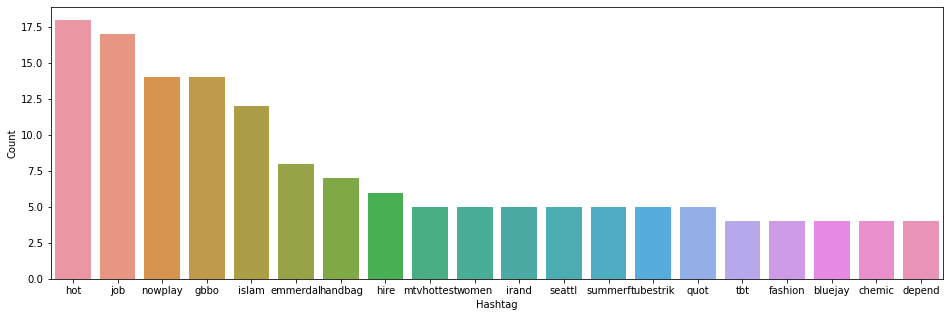

In [81]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Now we can see the disaster-related hashtags.

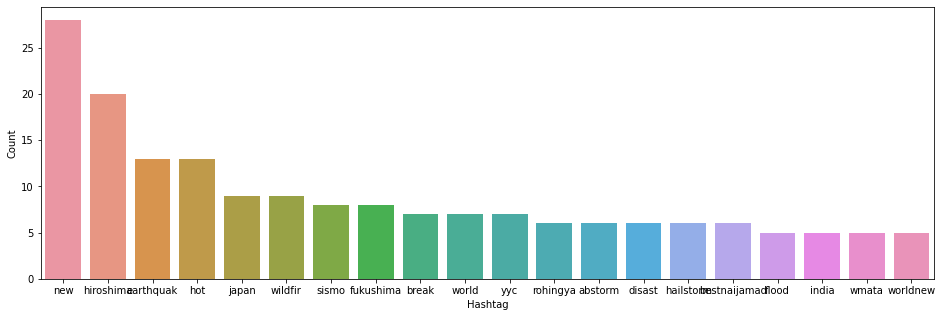

In [82]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Extracting Bag of Words Features

To analyze a preprocessed data, it needs to be converted into features. First, let's make a Bag-of-Words to represent text as numerical features.

In [83]:
# Create Bag-of-Words
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df_train['text'])
bow.shape

(7552, 1000)

### Extracting TF-IDF Features

We can also create a TF-IDF. TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Important terms related to TF-IDF:

1. TF = (Number of times term t appears in a document)/(Number of terms in the document)
2. IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
3. TF-IDF = TF*IDF

In [84]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df_train['text'])
tfidf.shape

(7552, 1000)

### Word Embeddings

In [85]:
tokenized_tweet_train = df_train['text'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet_train,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet_train, total_examples= len(df_train['text']), epochs=20)

(1098706, 1294360)

Let's explore the Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [86]:
model_w2v.wv.most_similar(positive="dinner")

[('banquet', 0.9277729988098145),
 ('#dutton', 0.8984915018081665),
 ('newlyw', 0.8872684240341187),
 ('viralspel', 0.8667844533920288),
 ('wed', 0.8551303148269653),
 ('#auspol', 0.8536356687545776),
 ('syrian', 0.843062162399292),
 ('wowo', 0.8373554944992065),
 ('cocain', 0.824201226234436),
 ('guest', 0.8240426778793335)]

In [87]:
model_w2v.wv.most_similar(positive="obama")

[('saipan', 0.8958649039268494),
 ('barack', 0.8892282843589783),
 ('#losdelsonido', 0.8770451545715332),
 ('declar', 0.8751124739646912),
 ('#ivanberroa', 0.8657128214836121),
 ('marian', 0.8652788996696472),
 ('comparison', 0.8615130186080933),
 ('commonwealth', 0.858536958694458),
 ('bash', 0.8504178524017334),
 ('abcnew', 0.8400537967681885)]

In [88]:
model_w2v['obama']

<ipython-input-88-03a6f62d740b>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_w2v['obama']


array([-0.8509885 , -0.26362792, -0.39449516, -0.13584153, -0.14402187,
        0.02371291,  0.11963557, -0.4006416 , -0.34119308,  0.1024807 ,
       -0.38544133,  0.05767948, -0.13745981, -0.23670463, -0.07968044,
       -0.24162586,  0.7134963 ,  0.30772105,  0.45572585, -0.11952033,
        0.5222214 ,  0.2129048 , -0.1640979 , -0.08389179, -0.3521987 ,
       -0.4407679 , -0.05047394,  0.521513  , -0.44930625, -0.34532803,
       -0.06139182,  0.14220661, -0.3590285 , -0.23918292,  0.20548955,
        0.25270844, -0.49269155, -0.19911063, -0.04842835, -0.18301658,
        0.1910939 ,  0.723608  , -0.19028   , -1.2261606 ,  0.02989313,
       -0.39986807,  0.43185377,  0.05851167, -0.36510268, -0.03743182,
       -0.07552022,  0.10319402, -0.00950172, -0.22901206, -0.00640777,
        0.17080127,  0.4621504 ,  0.48526424,  0.16545063, -0.19819683,
        0.08979417, -0.14218919, -0.2694553 ,  0.2606318 ,  0.07332828,
        0.6625095 ,  0.2564669 ,  0.31629673, -0.12137766,  0.50

In [89]:
len(model_w2v['obama']) #The length of the vector is 200

<ipython-input-89-ee0cf952e1e0>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  len(model_w2v['obama']) #The length of the vector is 200


200

### Preparing Vectors for Tweets

Let's make a function to give a vector to each tweet by taking the average of the vectors of the words present in the tweet.

In [90]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

Now, let's prepare the word2vec feature set.

In [91]:
wordvec_arrays = np.zeros((len(tokenized_tweet_train), 200))

for i in range(len(tokenized_tweet_train)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet_train[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-90-2f6882f45f7b>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(7552, 200)

Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.

### Doc2Vec Embedding

To being, import the libraries.

In [92]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

C:\Users\lukef\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [93]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [94]:
labeled_tweets = add_label(tokenized_tweet_train) # label all the tweets

<ipython-input-93-868d96c8c1ce>:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


Examine.

In [95]:
labeled_tweets[:6]

[LabeledSentence(words=['bbcmtd', 'wholesal', 'market', 'ablaz'], tags=['tweet_0']),
 LabeledSentence(words=['alway', 'bring', 'heavi', '#metal'], tags=['tweet_1']),
 LabeledSentence(words=['#africanbaz', 'break', 'news', 'nigeria', 'flag', 'ablaz'], tags=['tweet_2']),
 LabeledSentence(words=['cri', 'more', 'ablaz'], tags=['tweet_3']),
 LabeledSentence(words=['plu', 'side', 'look', 'last', 'night', 'ablaz'], tags=['tweet_4']),
 LabeledSentence(words=['phdsquar', '#mufc', 'they', 'have', 'built', 'much', 'hype', 'around', 'acquisit', 'doubt', 'they', 'will', 'ablaz', 'thi', 'season'], tags=['tweet_5'])]

We can now train a doc2vec model.

In [96]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

C:\Users\lukef\anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 7552/7552 [00:00<00:00, 688565.36it/s]


In [97]:
model_d2v.train(labeled_tweets, total_examples= len(df_train['text']), epochs=15)

### Preparing Doc2Vec Feature Set

In [98]:
docvec_arrays = np.zeros((len(tokenized_tweet_train), 200))

for i in range(len(df_train)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(7552, 200)

# 6. Model Building

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, Word2Vec vectors, and Doc2Vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
2. Support Vector Machine
3. RandomForest
4. XGBoost

To start, import libraries for logistic regression.

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### Bag of Words/Countervectorizer Features

In [100]:
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(df_train['text'])
test_cv = count_vectorizer.transform(df_test['text'])

print(train_cv[0].todense())

[[0 0 0 ... 0 0 0]]


### TFIDF Features

In [101]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(df_train['text'])
test_tfidf = tfidf.transform(df_test['text'])

### Model Performance Metrics

After implementing a model and getting some output in forms of a probability or a class, the next step is to find out how effective is the model based on some metric using test data sets.

As this is a classification model, suitable metrics of model performance are:

1. Confusion Matrix
2. F1 Score
3. Accuracy

### The Model

We will create a simple classification model using our algorithms and check how the model performs.

We being by splitting the CountVector vectorized data into train and test datas for model training and testing.

In [106]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv =train_test_split(train_cv,df_train.target,test_size=0.2,random_state=2020)

Now, define a function to fit and predict on training and test data sets, and fit a logisitic regression.

In [107]:
def fit_and_predict(model,X_train,y_train,X_test,y_test):
    
    '''Input- model=model to be trained
              X_train, y_train= traing data set
              X_test,  y_test = testing data set
       Output- Print accuracy of model for training and test data sets   
    '''
    
    # Fitting a simple Logistic Regression on Counts
    clf = model
    clf.fit(X_train, y_train)
    predictions=clf.predict(X_test)
    confusion_matrix(y_test,predictions)
    print(classification_report(y_test,predictions))
    print('-'*50)
    print("{}" .format(model))
    print('-'*50)
    print('Accuracy of classifier on training set:{}%'.format(round(clf.score(X_train, y_train)*100)))
    print('-'*50)
    print('Accuracy of classifier on test set:{}%' .format(round(accuracy_score(y_test,predictions)*100)))
    print('-'*50)

Then, create a list of the regression models to be used.

In [108]:
models=[LogisticRegression(C=1.0),SVC(),MultinomialNB(),DecisionTreeClassifier(),
        KNeighborsClassifier(n_neighbors=5),RandomForestClassifier()]

We can now loop through the model list and use our fit and predict function to train and make predictions.

In [109]:
for model in models:
    fit_and_predict(model,X_train_cv, y_train_cv,X_test_cv,y_test_cv)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       858
           1       0.79      0.71      0.75       653

    accuracy                           0.79      1511
   macro avg       0.79      0.78      0.79      1511
weighted avg       0.79      0.79      0.79      1511

--------------------------------------------------
LogisticRegression()
--------------------------------------------------
Accuracy of classifier on training set:94.0%
--------------------------------------------------
Accuracy of classifier on test set:79.0%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       858
           1       0.85      0.65      0.74       653

    accuracy                           0.80      1511
   macro avg       0.81      0.78      0.79      1511
weighted avg       0.81      0.80      0.79      1511

-----------------------------------

Now, we split the TFDIF vectorized data into train and test datasets for training and testing.

In [113]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf =train_test_split(train_tfidf,df_train.target,test_size=0.2,random_state=2020)

Then, loop through the model list again and use the fit and predict function to train and make predictions.

In [114]:
for model in models:
    fit_and_predict(model,X_train_tf, y_train_tf,X_test_tf,y_test_tf)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       858
           1       0.84      0.66      0.74       653

    accuracy                           0.80      1511
   macro avg       0.81      0.78      0.79      1511
weighted avg       0.81      0.80      0.80      1511

--------------------------------------------------
LogisticRegression()
--------------------------------------------------
Accuracy of classifier on training set:88.0%
--------------------------------------------------
Accuracy of classifier on test set:80.0%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       858
           1       0.85      0.64      0.73       653

    accuracy                           0.79      1511
   macro avg       0.81      0.77      0.78      1511
weighted avg       0.80      0.79      0.79      1511

-----------------------------------

# 7. Results

Let us now better visualize the accuracy of all the models employed.

In [124]:
results_dict_bow={'Classifier':['Logistic regression', 'SVC', 'MultinomialNB', 'DecisionTreeClassifier',
                            'KNeighborsClassifier','RandomForestClassifier'],
              'F1-Score':[0.79, 0.79, 0.78, 0.72, 0.64, 0.77],'Accuracy':['79%', '80%', '79%','75%','64%','78%']} 
results_bow=pd.DataFrame(results_dict_bow)
print("Results from Count Vectorizer/Bag of Words Model:")
results_bow

Results from Count Vectorizer/Bag of Words Model:


,Classifier,F1-Score,Accuracy
0,Logistic regression,0.79,79%
1,SVC,0.79,80%
2,MultinomialNB,0.78,79%
3,DecisionTreeClassifier,0.72,75%
4,KNeighborsClassifier,0.64,64%
5,RandomForestClassifier,0.77,78%


In [125]:
results_dict_TFIDF={'Classifier':['Logistic regression', 'SVC', 'MultinomialNB', 'DecisionTreeClassifier',
                            'KNeighborsClassifier','RandomForestClassifier'],
              'F1-Score':[0.80, 0.79, 0.79, 0.75, 0.63, 0.77],'Accuracy':['80%', '79%', '79%','72%','63%','78%']} 
results_TFIDF=pd.DataFrame(results_dict_TFIDF)
print("Results from TFIDF Model:")
results_TFIDF

Results from TFIDF Model:


,Classifier,F1-Score,Accuracy
0,Logistic regression,0.80,80%
1,SVC,0.79,79%
2,MultinomialNB,0.79,79%
3,DecisionTreeClassifier,0.75,72%
4,KNeighborsClassifier,0.63,63%
5,RandomForestClassifier,0.77,78%


It seems from all the classifiers tested, the logistic regression classifier performed best with TFIDF, so we shall fit the former with the latter.

In [143]:
# Fitting 'LogisticRegression()' with TFIDF() fit dataset
clf_logreg = LogisticRegression(C=1.0)
clf_logreg.fit(X_train_tf, y_train_tf)
pred=clf_logreg.predict(X_test_tf)
confusion_matrix(y_test_tf,pred)
print(classification_report(y_test_tf,pred))
print('Accuracy of classifier on training set:{}%'.format(round(clf_logreg.score(X_train_tf, y_train_tf)*100)))
print('Accuracy of classifier on test set:{}%' .format(round(accuracy_score(y_test_tf,pred)*100)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       858
           1       0.84      0.66      0.74       653

    accuracy                           0.80      1511
   macro avg       0.81      0.78      0.79      1511
weighted avg       0.81      0.80      0.80      1511

Accuracy of classifier on training set:88.0%
Accuracy of classifier on test set:80.0%


Though fitting it has not improved its accuracy, it has improved the F1 score.

Let's visualize its accuracy with a Confusion Matrix.

In [147]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
print(confusion_matrix(y_test_tf, pred, labels=[1,0]))

[[434 219]
 [ 82 776]]


Confusion matrix, without normalization
[[434 219]
 [ 82 776]]


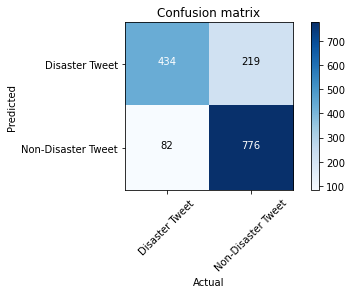

In [148]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tf, pred, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Disaster Tweet','Non-Disaster Tweet'],normalize= False,  title='Confusion matrix')

As we can see, the acuracy is high: From the test data, the model correctly predicted 434 disaster tweets (true positive) and 776 non disaster (true negative) tweets. In terms of inaccuracy, it identified 219 non-disaster tweets as disaster tweets (false positive), and 82 disaster tweets as non-disaster tweets (false negative).

### Model Improvement

The result from the logistic regression() classifier seems approriate to use as a final model. Based on the above results, it seems the classifier is not over fitting. However, we can try to improve the model by tuning some hyper parameters of the classifier.

In [149]:
# Create the list of various hyper parameters to try
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
logreg= LogisticRegression()

# Define and fit grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_tf, y_train_tf)

# Summarize and print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.796944 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


As we can observe above, however, the orignal classifier with default parameters performed best. It remains the final model for test data predictions.

# 8. Reflection

This was my first NPL project and my second data science project so learning how to do this was a challenge. Things I would consider/improve next time include:

1. The datasets: there was only about 7500 tweets off which to train the model which is quite small.
2. Working pre-split test and train datasets: towards the end of my project I got somewhat confused if it was correct to split my train data for my Count Vectorizer and TFIDF.
3. I would like to improve my understanding of how best, and when, to deploy and interpret my confusion matrix.
4. I would like to use functions next time for efficiency in cleaning and vectorizing data.
5. I would also like to learn how to employ the concept of log loss in logistical regression.

Overall, however, I am happy with how this project went for a first attempt and look forward to refining it and my approach to other NPL models as my experience and knowledge grows.